In [1]:
# import libraries
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


Основная сложность работы с такими рядами, как в нашем проекте, заключается в том, как учесть  сложную структуру сезонности — суточной, недельной и годовой. В рамках моделей ARIMA можно учесть только одну из них. Обычно в таких случаях сезонность с самым маленьким периодом явно моделируют с помощью аримы, а все остальные учитывают за счёт регрессионной компоненты.

Для учёта недельной сезонности используются регрессионные признаки следующего вида: 

$$s_i = \sin \left( [1,\dots,T] * 2 \pi i/ 168 \right)$$ $$c_i = \cos \left( [1,\dots,T] * 2 \pi i/ 168 \right), i=1,\dots, K.$$

Здесь T — это длина моделируемого ряда, 168 — длительность недели в часах, а значение параметра K вам предстоит подобрать самостоятельно (в зависимости от длины подготовленного ряда, можно для начала взять K равным 2-5).

In [2]:
# Download data for half a 2016 year
df = pd.read_csv('NYC_2016_01-06.csv')
df.index = np.arange(4368)
df

,1,2,3,4,5,6,7,8,9,10,...,2492,2493,2494,2495,2496,2497,2498,2499,2500,time
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-01-01 00
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-01-01 01
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-01-01 02
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-01-01 03
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-01-01 04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-06-30 19
4364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-06-30 20
4365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-06-30 21
4366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2016-06-30 22


In [3]:
# I choosed box 1282, where max values of all trip because there will be max error
data_all = df.iloc[:, 1281:1282]
data_all.head(3)

,1282
0,1076
1,1178
2,1053


### 1. Выберать одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. 
Не использовать данные за последний имеющийся месяц — июнь 2016!

In [4]:
# June 2016 have 30 days => 30*24 = 720; 4367-720 = 3647
data = data_all.iloc[:3648]
data

,1282
0,1076
1,1178
2,1053
3,610
4,401
...,...
3643,1909
3644,1694
3645,1492
3646,1089


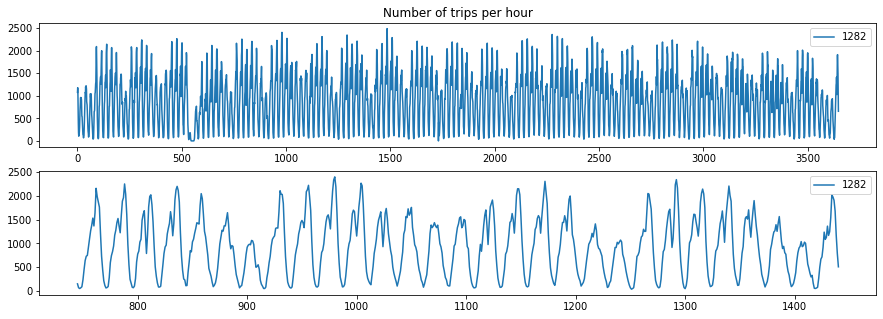

In [5]:
ax = plt.subplot(211)
data.plot(figsize=(15, 5), title='Number of trips per hour', ax=ax)
# Let's look data more nearer in February
ax = plt.subplot(212)
data.iloc[745:1441].plot(figsize=(15, 5), ax=ax);

1. На данных нет тренда
2. На данных нет возрастающей дисперсии
3. На данных заметна сезонность

<ipython-input-6-46ffc344f145>:1: RuntimeWarning: divide by zero encountered in log
  trend = np.log(data['1282'].values) - np.log(data['1282'].shift(1).values)
<ipython-input-6-46ffc344f145>:1: RuntimeWarning: invalid value encountered in subtract
  trend = np.log(data['1282'].values) - np.log(data['1282'].shift(1).values)


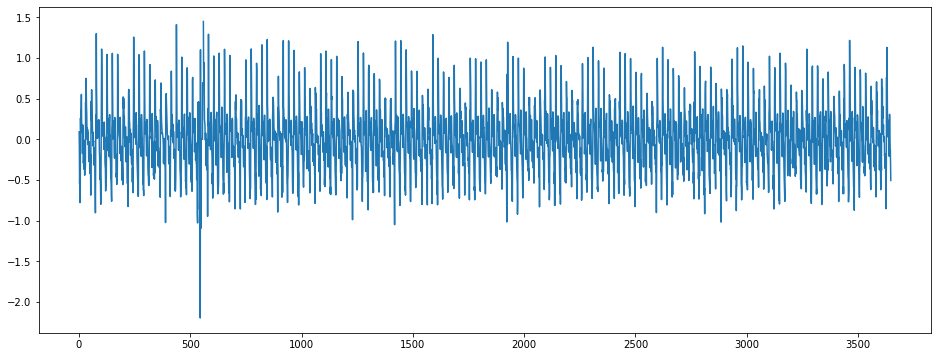

In [6]:
trend = np.log(data['1282'].values) - np.log(data['1282'].shift(1).values)
plt.figure(figsize=(16, 6))
plt.plot(trend);

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x864 with 0 Axes>

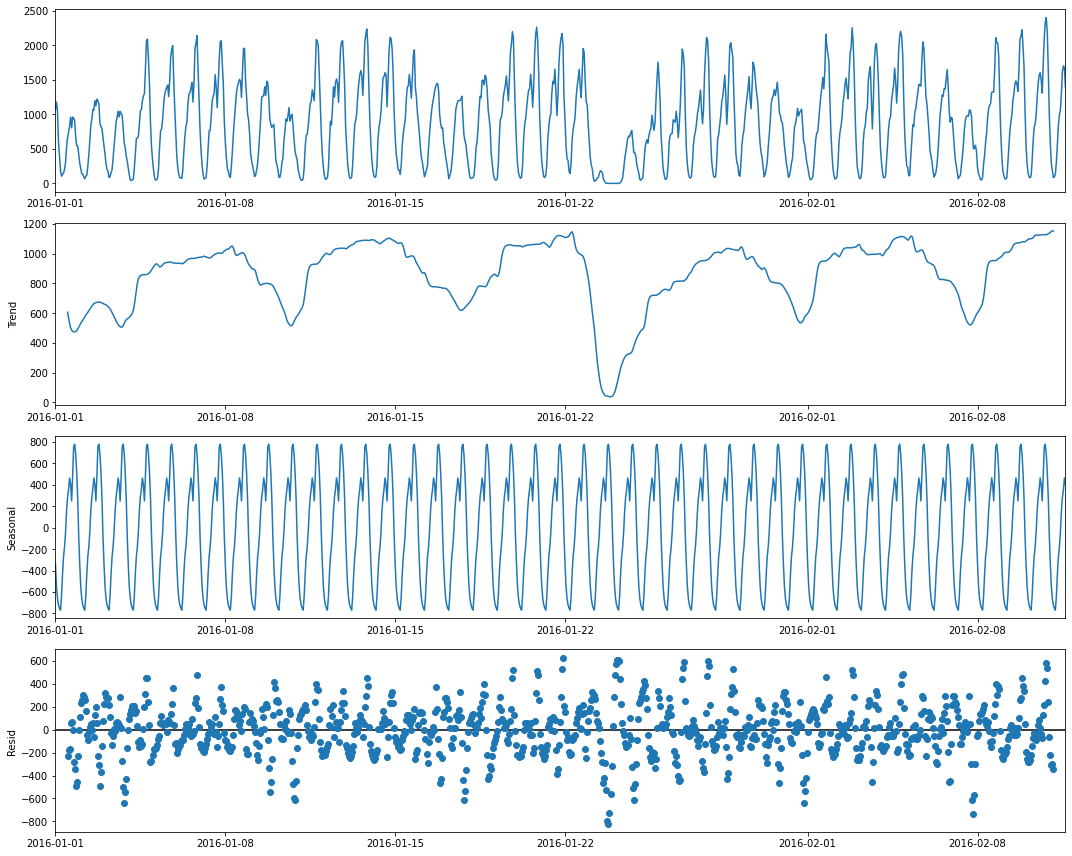

In [7]:
# Check the 1282 box to stationarity
data.index = pd.date_range(start='1/1/2016', end='6/1/2016', freq='H', closed='left')
plt.figure(figsize(15,12))
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['1282'])[1])
sm.tsa.seasonal_decompose(data.iloc[:1000]).plot();

#### Создадим регрессионные признаки для учёта сезонностей и трендов.

In [9]:
# Create constant and new regression features matrix for seasons and trands
pi = np.math.pi
K = 50
reg_feature = np.zeros((len(data_all), K*2))
# Let's fill the array with features
for j in range(K):
    for i in range(len(reg_feature)):      
        reg_feature[i,j*2] = np.sin((i+1)*2*pi*(j+1)/168.)
        reg_feature[i,j*2+1] = np.cos((i+1)*2*pi*(j+1)/168.)
                
reg_feature.shape

(4368, 100)

### 2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделаем регрессию целевого признака — количества поездок — на построенные признаки. 

Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, mean_absolute_error

In [11]:
# Split the sample to train and test
X_train, X_test, y_train, y_test = train_test_split(reg_feature, data_all['1282'].values, test_size=720, random_state=1)

# Create and fit models with default settings
Lin_reg_clf = LinearRegression().fit(X_train, y_train)
Lasso_clf = Lasso().fit(X_train, y_train)
Ridge_clf = Ridge().fit(X_train, y_train)

In [12]:
# Get predictions
predict_lin_reg = Lin_reg_clf.predict(X_test)
predict_lasso = Lasso_clf.predict(X_test)
predict_ridge = Ridge_clf.predict(X_test)
# Looks on their metrics
mae_lin_reg = mean_absolute_error(y_test, predict_lin_reg)
mae_lasso = mean_absolute_error(y_test, predict_lasso)
mae_ridge = mean_absolute_error(y_test, predict_ridge) 

[mae_lin_reg, mae_lasso, mae_ridge]

[93.78176972867784, 94.00202045478291, 93.8023645625611]

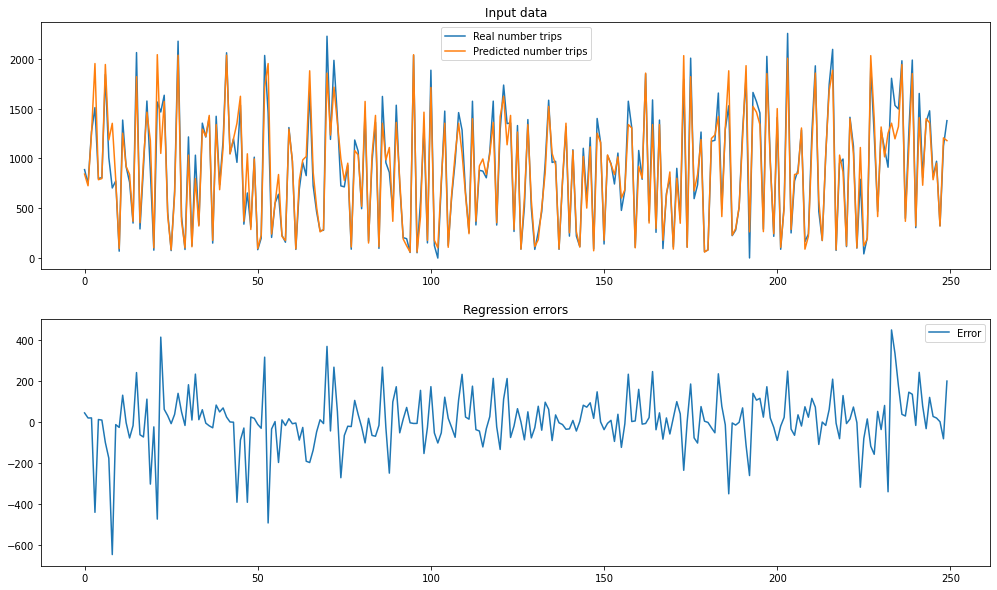

In [13]:
# I choose lasso regression. It have min MSE
reg_errors = y_test - predict_lasso

plt.figure(figsize=(17, 10))
plt.subplot(211)
plt.plot(y_test[:250], label='Real number trips')
plt.plot(predict_lasso[:250], label='Predicted number trips')
plt.title('Input data')
plt.legend()

plt.subplot(212)
plt.plot(reg_errors[:250], label='Error')
plt.title('Regression errors')
plt.legend();

Тренда я не наблюдаю, но сезонность присутствует, а так-же большие выбросы - аномалии

### 3. Для подобра значения гиперпараметров ARIMA,  сделаем ряд остатков стационарным. 
Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

In [14]:
# Create new table of regression errors
indx = pd.date_range(start='6/1/2016', end='7/1/2016', freq='H', closed='left')
errors = pd.DataFrame(reg_errors, index=indx, columns=['error'])
errors

,error
2016-06-01 00:00:00,44.532233
2016-06-01 01:00:00,19.784745
2016-06-01 02:00:00,19.991091
2016-06-01 03:00:00,-441.842559
2016-06-01 04:00:00,12.199484
...,...
2016-06-30 19:00:00,-272.958881
2016-06-30 20:00:00,-76.750200
2016-06-30 21:00:00,120.501616
2016-06-30 22:00:00,-48.357014


<Figure size 1296x720 with 0 Axes>

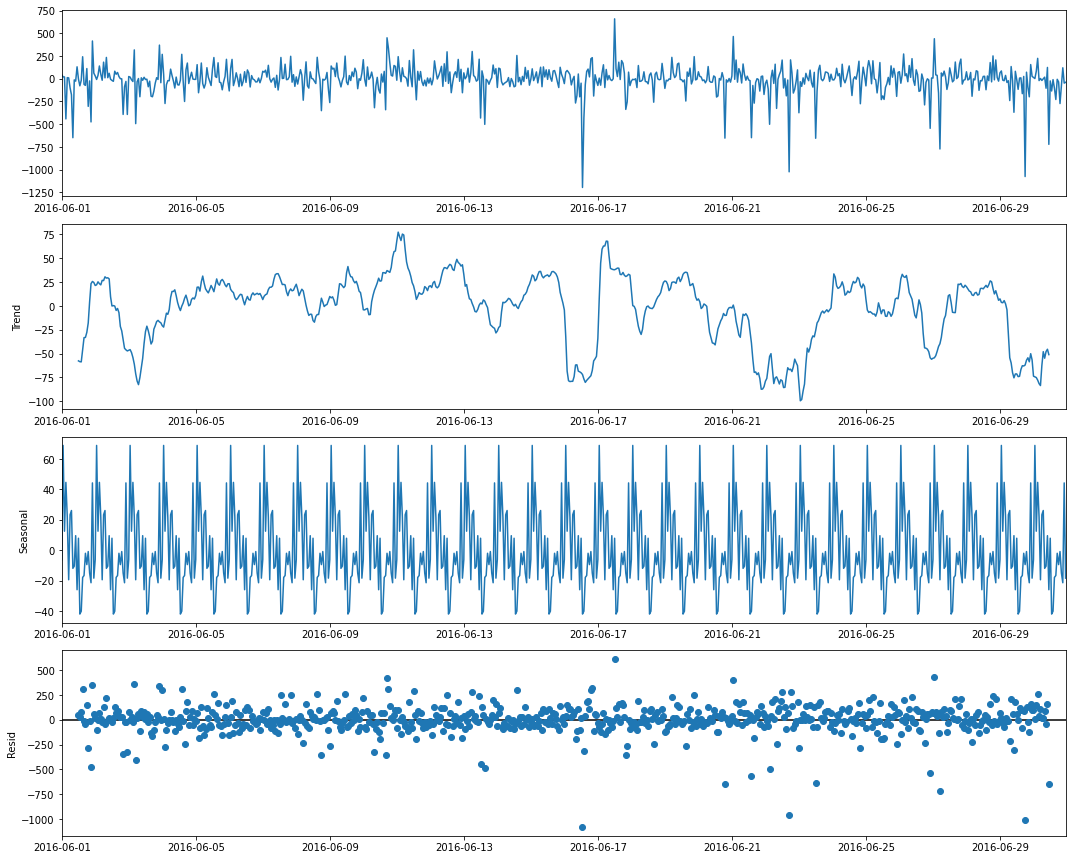

In [15]:
# Let's check stationarity
plt.figure(figsize=(18, 10))
sm.tsa.seasonal_decompose(errors).plot();

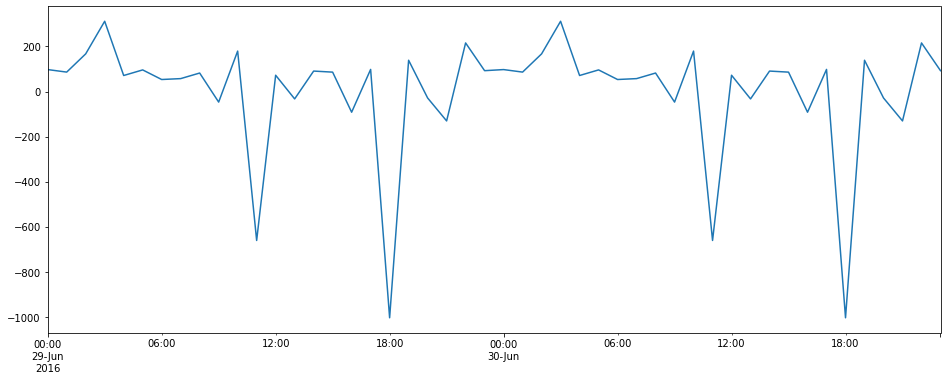

In [16]:
# Here the seasonality of the last 240 hours
plt.figure(figsize=(16, 6))
sm.tsa.seasonal_decompose(errors.error[-48:]).seasonal.plot();

<Figure size 1080x576 with 0 Axes>

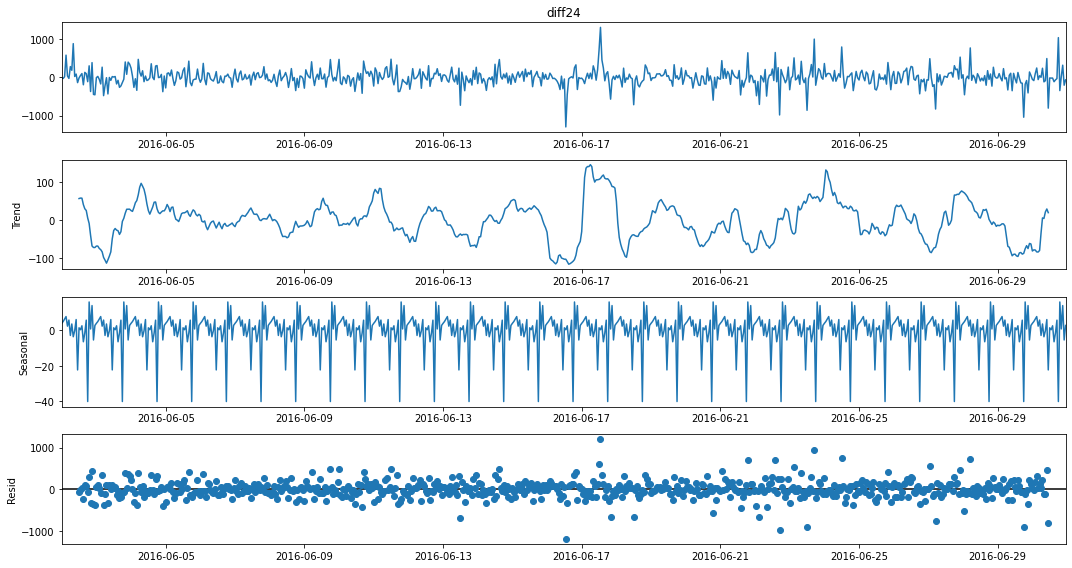

In [17]:
# Let's difference errors to 168 hour (1 week)
errors['diff168'] = errors.error - errors.error.shift(168)
errors['diff24'] = errors.error - errors.error.shift(24)

plt.figure(figsize(15,8))
sm.tsa.seasonal_decompose(errors.diff24[24:]).plot();

### 4. Построим ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год) и подберём по ним начальные приближения для параметров p, q, P, Q. 
Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

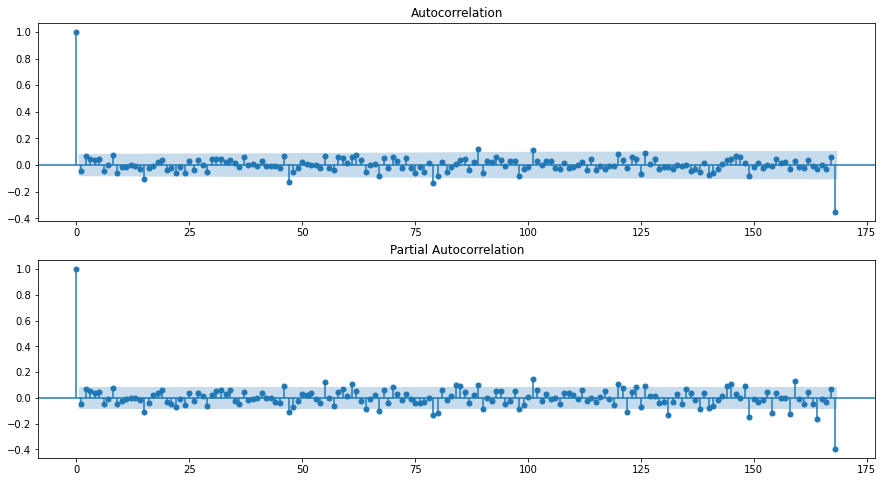

In [18]:
# Here ACF and PACF with difference 168
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(errors.diff168[168:].values, lags=168, ax=ax)
#sm.graphics.tsa.plot_acf(errors.error.values, lags=168, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(errors.diff168[168:].values, lags=168, ax=ax)
#sm.graphics.tsa.plot_pacf(errors.error.values, lags=168, ax=ax)
pylab.show()


Глядя на графики можно предположить начальные приближения:
Q и q - Autocorrelation, P и p - Partial Autocorrelation
1. Номер максимального сезонного лага, значимо отличающегося от нуля (Q) - **1**. Так как лаг 168 выходит за доверительный уровень значимости.
2. Номер последнего несезонного лага, значимо отличающиеся от нуля (q) - **0**. 
3. Номер последнего сезонного лага, значимо отличающийся от 0 (P) - **1**.
4. Номер последнего несезонного лага, значимо отличающийся от 0 (p) - **0**

In [19]:
# 
Q = [1]
q = [0]
P = [1]
p = [0]
d, D = 1, 1

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

1

In [20]:
# regressor sign
exog_ = sm.add_constant(X_train)

In [21]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(endog=data['1282'], order=(param[0], d, param[1]), exog=exog_, 
                                          seasonal_order=(param[2], D, param[3], 24)).fit(disp=False)  
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 17min 29s


In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by ='aic', ascending=True).head())

     parameters           aic
0  (0, 0, 1, 1)  44969.112483


C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 1282   No. Observations:                 3648
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 24)   Log Likelihood              -22380.556
Date:                              Wed, 21 Jul 2021   AIC                          44969.112
Time:                                      12:36:06   BIC                          45613.398
Sample:                                  01-01-2016   HQIC                         45198.647
                                       - 05-31-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005   1.89e+04   2.77e-08      1.000    -3.7e+04     3.7e+04
x1            -0.33

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу (если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения p, q, P, Q.)

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


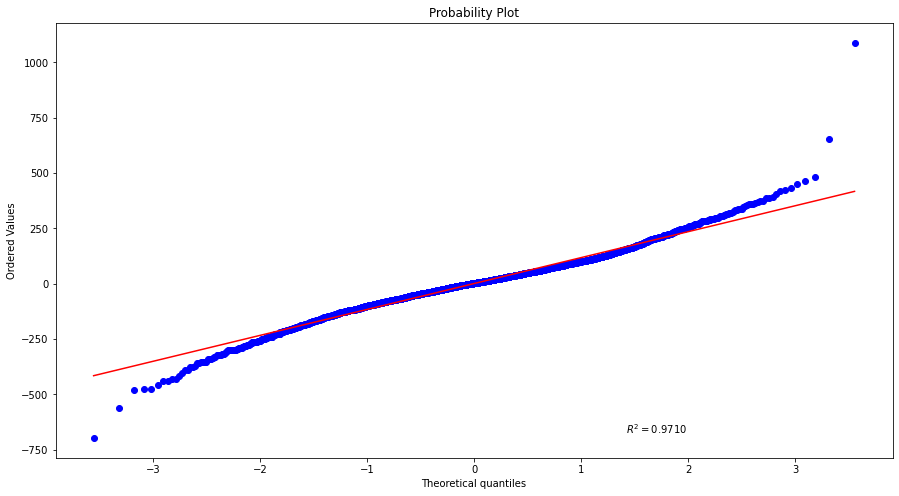

In [24]:
# Check our model to normal distribution
stats.probplot(best_model.resid, dist="norm", plot=pylab, rvalue=True);

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.650338
Критерий Дики-Фуллера: p=0.000000


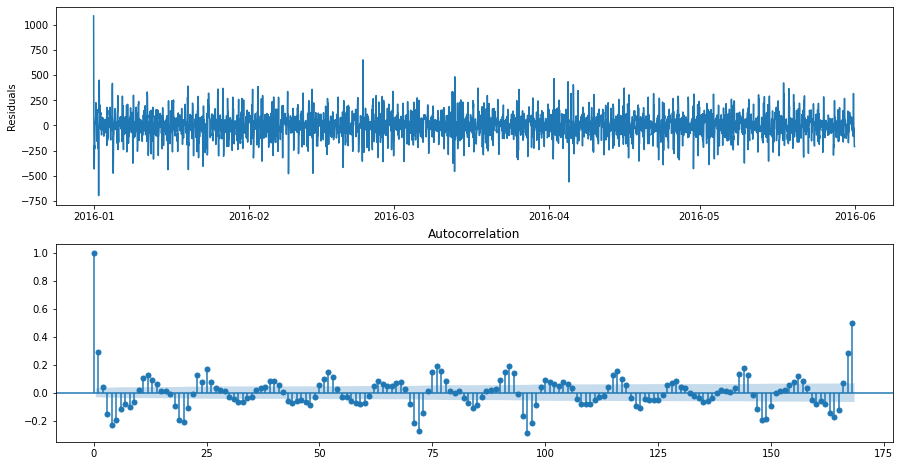

In [25]:
plt.figure(figsize(15,8))
plt.subplot(211)
plt.plot(best_model.resid)
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid, lags=168, ax=ax) 

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

В данных ещё есть информация

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Николай\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


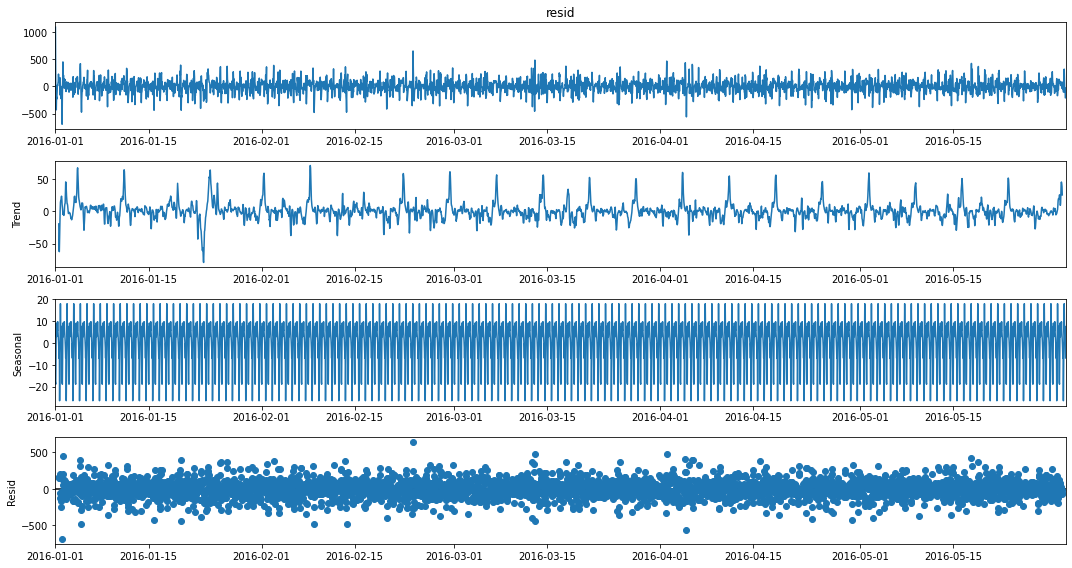

In [26]:
data['resid'] = best_model.resid.values
sm.tsa.seasonal_decompose(data['resid']).plot();

### 5. Выберем оптимальную по AIC модель и построим график исходного ряда. Нарисуем поверх предсказания выбранной модели. 
Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов K или поменять порядки дифференцирования.

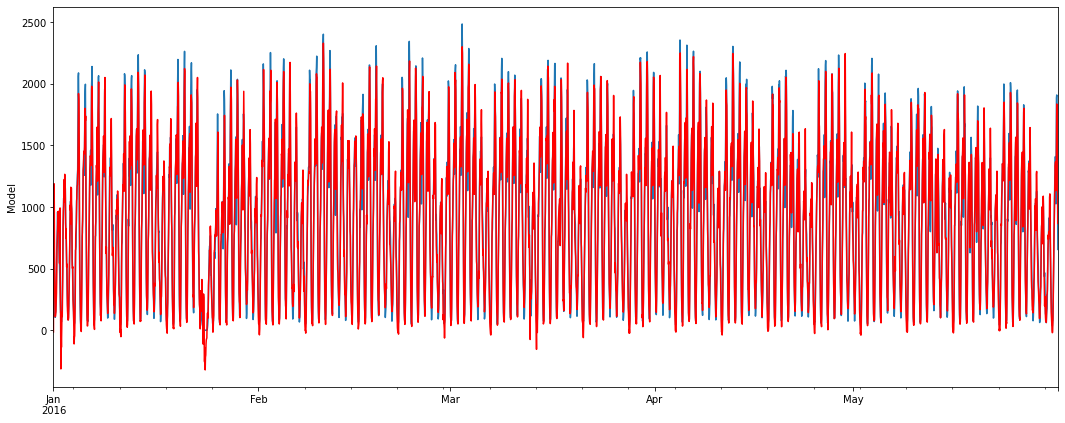

In [27]:
# Show fitted values
data['model'] = best_model.fittedvalues
plt.figure(figsize(18,7))

data['1282'].plot()
data.model.plot(color='r')
plt.ylabel('Model')
plt.show()

In [28]:
mse_sarima = mean_absolute_error(data['1282'], data.model)
mse_sarima

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


87.07433256115223

Выглядит хорошо

### 6. Проанализируем качество построенной модели. 
Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

Некоторые значения отрицательные, а такого быть не может. Думаю можно сделать и лучше при переборе параметров для SARIMA (компьютер не потянет).
 
 Попробую добавить к признакам в регрессию праздники и признаки дня. Так-же на остатках модели можно заново обучиться и прибавить новые значения к предыдущим.

# New features

In [29]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# For 01-06
data.index = pd.date_range(start='1/1/2016', end='6/1/2016', freq='H', closed='left')
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data["is_weekend"] = data.weekday.isin([5, 6]) * 1

# For June
data_all.index = pd.date_range(start='1/1/2016', end='7/1/2016', freq='H', closed='left')
data_all["hour"] = data_all.index.hour
data_all["weekday"] = data_all.index.weekday
data_all["is_weekend"] = data_all.weekday.isin([5, 6]) * 1
data_all.sample(5)

C:\Users\Николай\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,1282,hour,weekday,is_weekend
2016-01-12 04:00:00,69,4,1,0
2016-02-02 03:00:00,64,3,1,0
2016-04-04 16:00:00,1188,16,0,0
2016-06-09 07:00:00,559,7,3,0
2016-06-28 11:00:00,1177,11,1,0


In [31]:
# code_mean(data, "weekday", "1282")

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# считаем средние только по тренировочной части, чтобы избежать лика
data["weekday_average"] = list(map(code_mean(data, "weekday", '1282').get, data.weekday))
data["hour_average"] = list(map(code_mean(data, "hour", '1282').get, data.hour))

# выкидываем закодированные средними признаки
data.drop(["hour", "weekday"], axis=1, inplace=True)

data.sample(3)

C:\Users\Николай\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\Николай\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,1282,resid,model,is_weekend,weekday_average,hour_average
2016-01-18 01:00:00,180,26.105852,153.894148,0,887.861742,361.151316
2016-03-20 16:00:00,1031,165.518030,865.481970,1,621.435606,1097.368421
2016-04-13 07:00:00,545,-25.724766,570.724766,0,1031.569444,428.375000


In [33]:
from pandas.tseries.holiday import *

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
# Add holidays to data
data_all['holiday'] = 0
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=datetime(2016, 1, 1), end=datetime(2016, 5, 31)) 
# Сonvert it to the needed format and substitute it in the data
h_days = pd.to_datetime(holidays).strftime('%Y-%m-%d')
for h in h_days:
    data_all.holiday[h] = 1

# Create constant and new regression features matrix for seasons and trands
pi = np.math.pi
K = 100
X_train = np.zeros((len(data), (K*2)+4))
# Let's fill the array with features
for k in range(K):
    for i in range(len(X_train)):      
        X_train[i,k*2] = sin((i+1)*2*np.pi*(k+1)/168.)
        X_train[i,k*2+1] = cos((i+1)*2*np.pi*(k+1)/168.)
                       
# Add holidays in reg_feature
X_train[:, -1] = data_all.iloc[:-720].holiday.values
X_train[:, -2] = data.is_weekend.values
X_train[:, -3] = data.weekday_average.values
X_train[:, -4] = data.hour_average.values
                       
X_train.shape

<ipython-input-34-7ea4679eb213>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all.holiday[h] = 1
C:\Users\Николай\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(3648, 204)

In [35]:
# считаем средние только по тренировочной части, чтобы избежать лика
data_all["weekday_average"] = list(map(code_mean(data_all, "weekday", '1282').get, data_all.weekday))
data_all["hour_average"] = list(map(code_mean(data_all, "hour", '1282').get, data_all.hour))

# выкидываем закодированные средними признаки
data_all.drop(["hour", "weekday"], axis=1, inplace=True)

data_all.sample(3)

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,1282,is_weekend,holiday,weekday_average,hour_average
2016-01-29 15:00:00,1236,0,0,936.623397,1259.164835
2016-03-16 09:00:00,777,0,0,1015.870192,732.961538
2016-04-09 15:00:00,1489,1,0,759.251603,1259.164835


In [36]:
# Create constant and new regression features matrix for seasons and trands
pi = np.math.pi
K = 100
reg_feats = np.zeros((len(data_all), (K*2)+4))
# Let's fill the array with features
for k in range(K):
    for i in range(len(reg_feats)):      
        reg_feats[i,k*2] = sin((i+1)*2*np.pi*(k+1)/168.)
        reg_feats[i,k*2+1] = cos((i+1)*2*np.pi*(k+1)/168.)
                       
# Add holidays in reg_feature
reg_feats[:, -1] = data_all.holiday.values
reg_feats[:, -2] = data_all.is_weekend.values
reg_feats[:, -3] = data_all.weekday_average.values
reg_feats[:, -4] = data_all.hour_average.values

X_test = reg_feats[-720:, :]
X_test.shape

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(720, 204)

In [37]:
# Split the sample to train and test
y_train = data['1282']
y_test = data_all['1282'].iloc[-720:]

# Create and fit models with default settings
Lin_reg_clf = LinearRegression().fit(X_train, y_train)
Lasso_clf = Lasso().fit(X_train, y_train)
Ridge_clf = Ridge().fit(X_train, y_train)

# Get predictions
predict_lin_reg = Lin_reg_clf.predict(X_test)
predict_lasso = Lasso_clf.predict(X_test)
predict_ridge = Ridge_clf.predict(X_test)
# Looks on their metrics
mae_lin_reg = mean_absolute_error(y_test, predict_lin_reg)
mae_lasso = mean_absolute_error(y_test, predict_lasso)
mae_ridge = mean_absolute_error(y_test, predict_ridge) 

[mae_lin_reg, mae_lasso, mae_ridge]

[156079297069.7598, 77.54127825786568, 76.88857365864394]

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


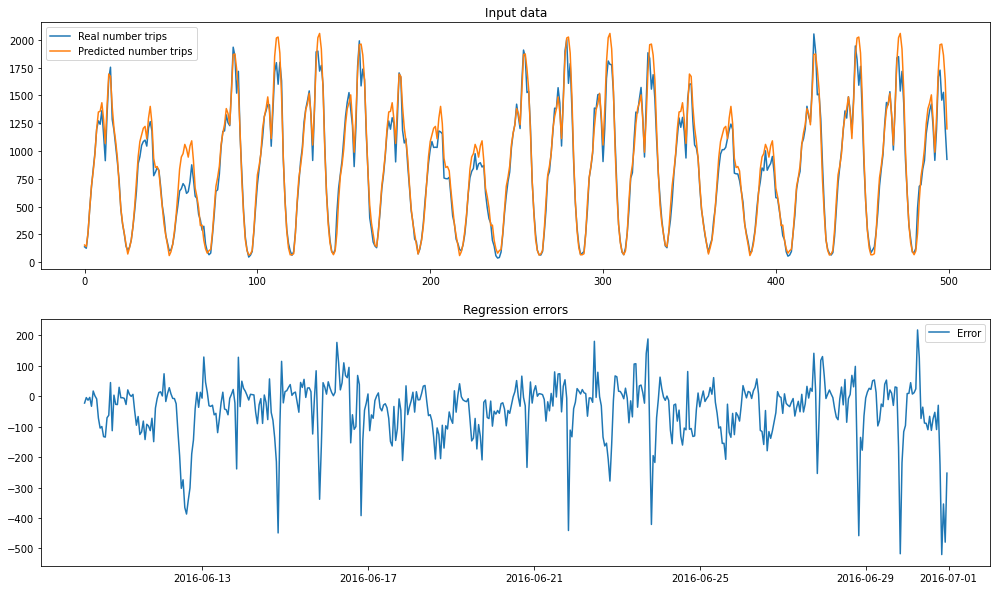

In [38]:
# I choose Ridge regression. It have min MAE
reg_errors = y_test - predict_ridge

plt.figure(figsize=(17, 10))
plt.subplot(211)
plt.plot(y_test[-500:].values, label='Real number trips')
plt.plot(predict_lasso[-500:], label='Predicted number trips')
plt.title('Input data')
plt.legend()

plt.subplot(212)
plt.plot(reg_errors[-500:], label='Error')
plt.title('Regression errors')
plt.legend();

In [39]:
# Create new table of regression errors
indx = pd.date_range(start='6/1/2016', end='7/1/2016', freq='H', closed='left')
errors = pd.DataFrame(reg_errors.values, index=indx, columns=['error'])
errors

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,error
2016-06-01 00:00:00,-121.396151
2016-06-01 01:00:00,-38.542022
2016-06-01 02:00:00,-10.554747
2016-06-01 03:00:00,7.713210
2016-06-01 04:00:00,13.188845
...,...
2016-06-30 19:00:00,-224.218724
2016-06-30 20:00:00,-520.093089
2016-06-30 21:00:00,-353.777651
2016-06-30 22:00:00,-479.344646


C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1080x576 with 0 Axes>

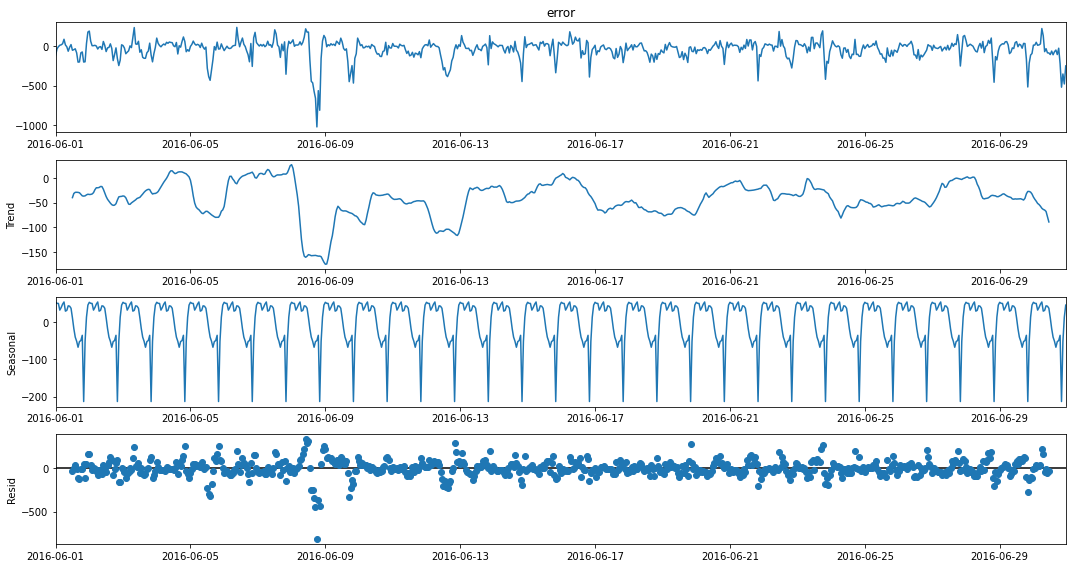

In [40]:
plt.figure(figsize(15,8))
sm.tsa.seasonal_decompose(errors.error).plot();

<Figure size 1080x576 with 0 Axes>

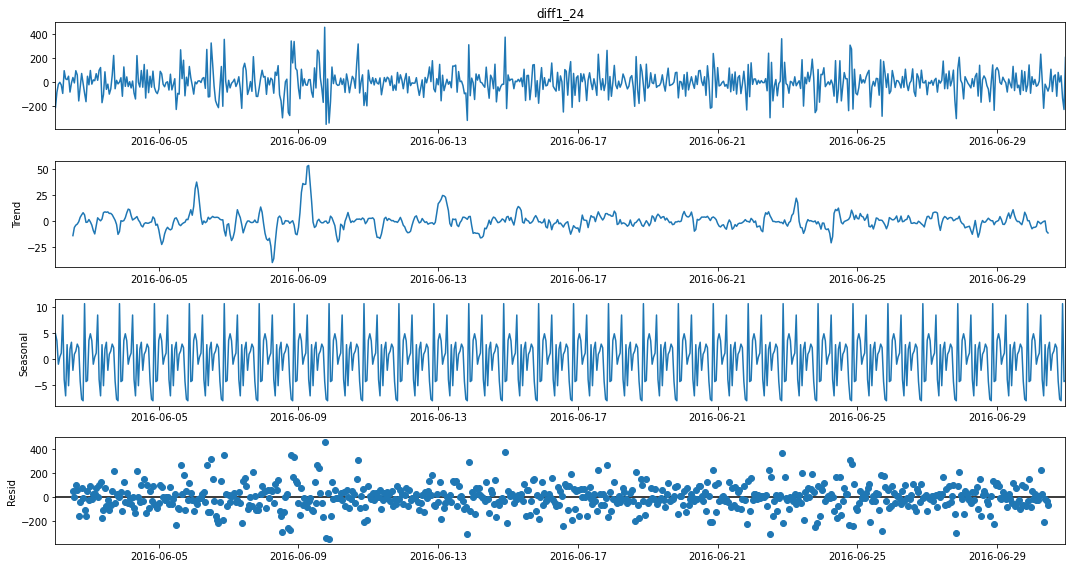

In [41]:
# Let's difference errors to 24 hour (1 day)
errors['diff1'] = errors.error - errors.error.shift(1)
errors['diff1_24'] = errors['diff1'] - errors['diff1'].shift(24)

plt.figure(figsize(15,8))
sm.tsa.seasonal_decompose(errors.diff1_24[25:]).plot();

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


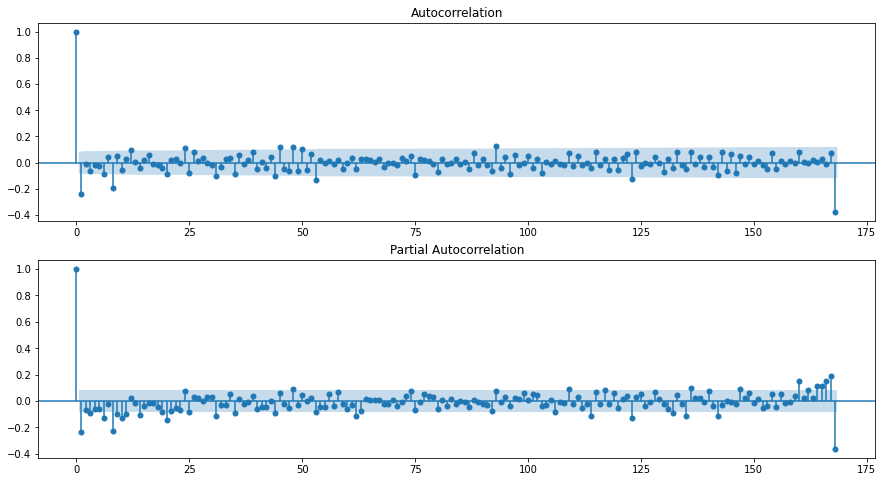

In [79]:
errors['diff1_168'] = errors['diff1'] - errors['diff1'].shift(168)

# Let's see ACF and PACF
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(errors.diff1_168[169:], lags=168, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(errors.diff1_168[169:], lags=168, ax=ax)
pylab.show()

In [80]:
exog = sm.add_constant(X_train)
# 
Q = [1, 2]
q = [1]
P = [1]
p = [1]
d, D = 1, 1

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2

In [81]:
data['1282'].values.shape, exog.shape, X_train.shape

((3648,), (3648, 205), (3648, 204))

In [82]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(endog=data['1282'].values, order=(param[0], d, param[1]), #exog=exog, 
                                          seasonal_order=(param[2], D, param[3], 24)).fit(disp=False)  
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 7min 3s


In [83]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by ='aic', ascending=True).head())
print(best_model.summary())

     parameters           aic
1  (1, 1, 1, 2)  44478.840319
0  (1, 1, 1, 1)  44515.643405
                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                 3648
Model:             SARIMAX(1, 1, 1)x(1, 1, [1, 2], 24)   Log Likelihood              -22233.420
Date:                                 Wed, 21 Jul 2021   AIC                          44478.840
Time:                                         15:04:35   BIC                          44516.011
Sample:                                              0   HQIC                         44492.083
                                                - 3648                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


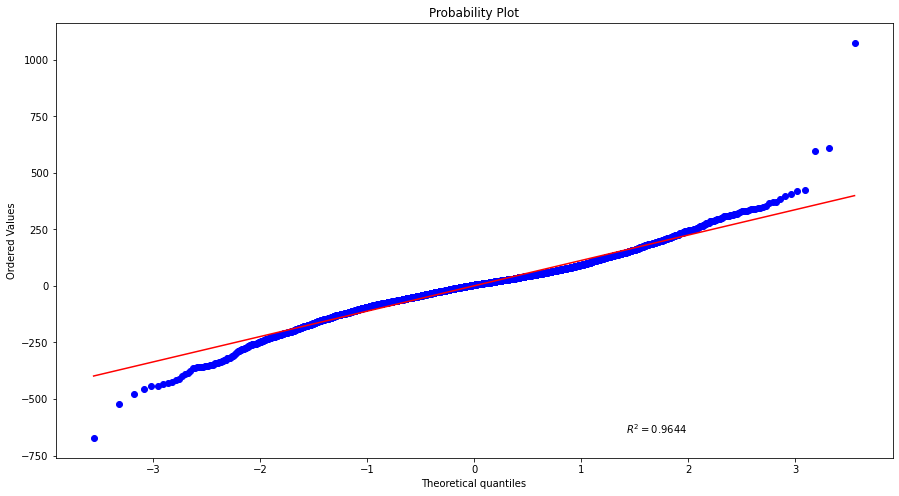

In [84]:
# Check our model to normal distribution
stats.probplot(best_model.resid, dist="norm", plot=pylab, rvalue=True);

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.774055
Критерий Дики-Фуллера: p=0.000000


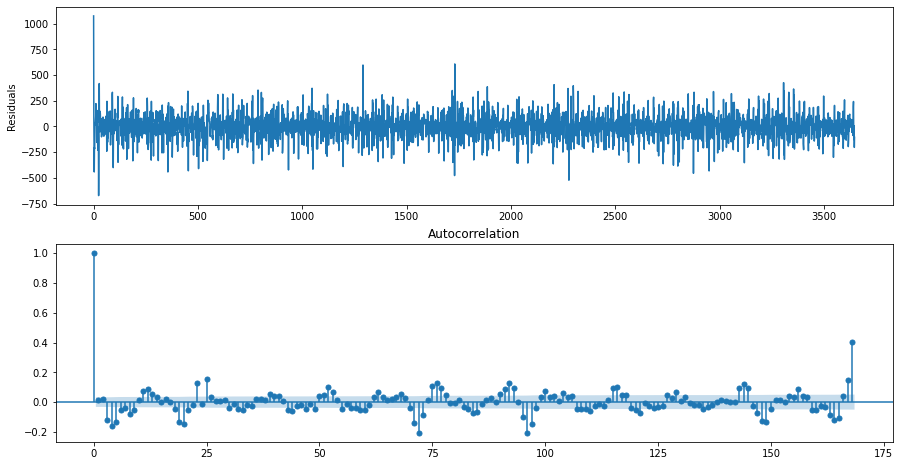

In [85]:
plt.figure(figsize(15,8))
plt.subplot(211)
plt.plot(best_model.resid)
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid, lags=168, ax=ax) 

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Николай\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


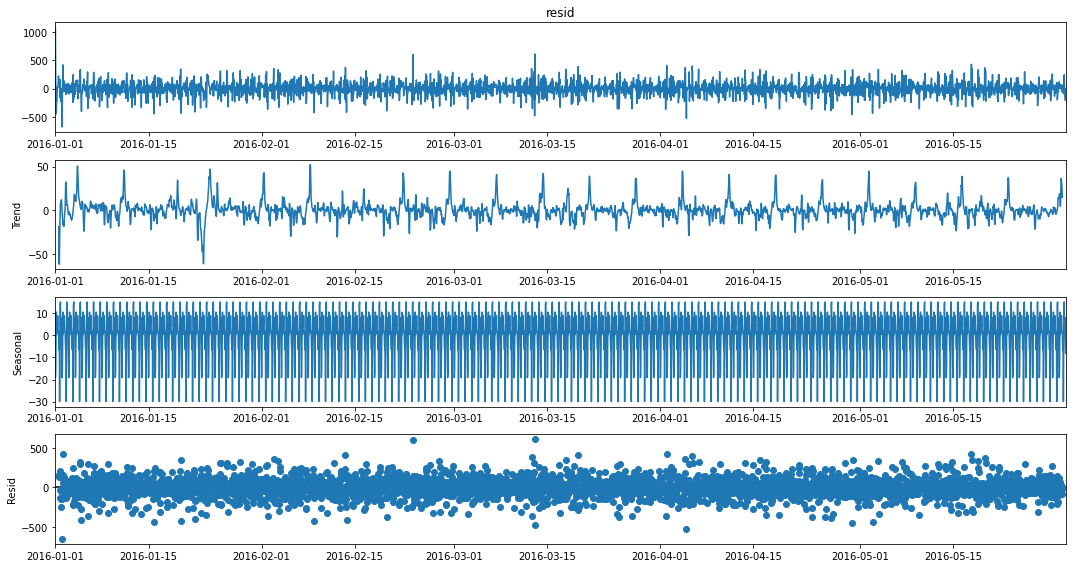

In [86]:
data['resid'] = best_model.resid
sm.tsa.seasonal_decompose(data['resid']).plot();

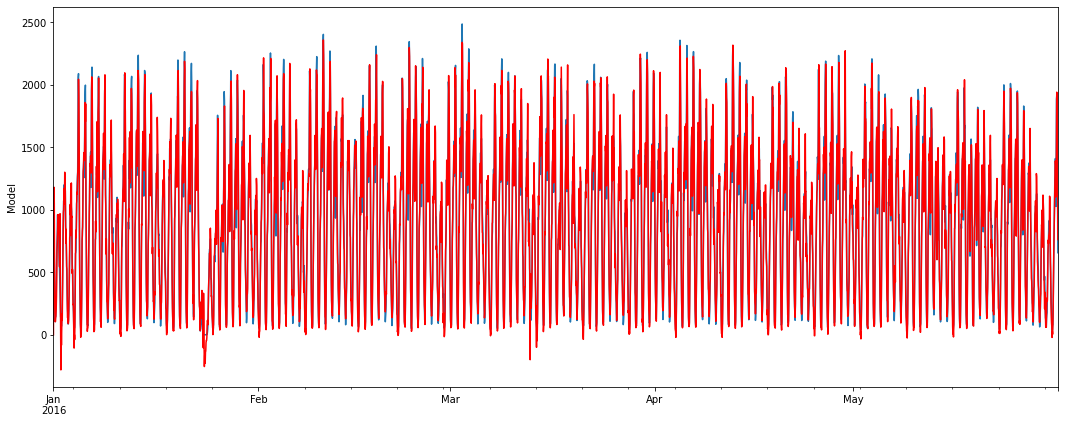

In [87]:
# Show fitted values
data['model'] = best_model.fittedvalues
plt.figure(figsize(18,7))

data['1282'].plot()
data.model.plot(color='r')
plt.ylabel('Model')
plt.show()

In [88]:
mse_sarima = mean_absolute_error(data['1282'], data.model)
mse_sarima

C:\Conda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


82.51061163819627